In [217]:
import math
import json
import os
import sys
import pdb
from itertools import compress

import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
#import seaborn as sn
#import scipy.stats
from scipy import stats
import scipy.stats
import scipy.optimize

sys.path.insert(1, '../../Databank/Scripts/BuildDatabank/')
from databankLibrary import download_link, lipids_dict, databank

In [58]:
path = '../Data/Flipflops/'
db_data = databank(path)
systems = db_data.get_systems()

In [59]:
def averageOrderParameters(system):
    pathTMP = system['path']
    path = pathTMP.replace('../Data/Flipflops/', '../../Databank/Data/Simulations/')
    sn1sum = 0
    sn1count = 0
    sn2sum = 0
    sn2count = 0
    
    for lipid in system['COMPOSITION']:
        if lipid in lipids_dict and not 'CHOL' in lipid:
            OPpathSIM = f'{path}{lipid}OrderParameters.json'
            with open(OPpathSIM) as json_file:
                OPsim = json.load(json_file)
    
            for key in OPsim:
                if 'M_G1C' in key:
                    sn1sum += float(OPsim[key][0][0])
                    sn1count += 1
                elif 'M_G2C' in key:
                    sn2sum += float(OPsim[key][0][0])
                    sn2count += 1

    return (-sn1sum/sn1count -sn2sum/sn2count)/2

def GetThickness(system):
    path = system['path']
    ThicknessPath = path.replace('../Data/Flipflops/', '../../Databank/Data/Simulations/')
    ThicknessPath = f'{ThicknessPath}thickness.json'
    #try:
    f = open(ThicknessPath)
    thickness = json.load(f)
    return(thickness)

def CalcAreaPerMolecule(system):
    path = system['path']
    APLpath = path.replace('../Data/Flipflops/', '../../Databank/Data/Simulations/')
    APLpath = f'{APLpath}apl.json'
    f = open(APLpath)
    APLdata = json.load(f)
    sumAPL = 0
    sumIND = 0
    for i,j in APLdata.items():
        sumAPL += j
        sumIND += 1
    APL = sumAPL/sumIND
    return(APL)
        
def getFlipflop(path):
    try:
        f = open(f'{path}flipflop.dat', 'r')
    except:
        print("no file")
        return np.array([]), [], []
        
    lines = f.readlines()[1:]
    flipflops = [line.split('    ') for line in lines]
    names = [line[0] for line in flipflops]
    flipflops = [line[1:] for line in flipflops]
    list_names = list(set(names))
    
    if len(flipflops) == 0:
        flipflops = np.array(flipflops)
        flipflops = flipflops.astype('int64')
        return flipflops, [], []
    
    for flip in flipflops:
        if flip[-1] == 'Success\n':
            flip[-1] = '1'
        else:
            flip[-1] = '0'
        #flip[0] = dict_names[flip[0]]
        
    flipflops = np.array(flipflops)
    flipflops = flipflops.astype('int64')
    #print(flipflops)
    return flipflops, names, list_names

In [227]:
def plotCorrelation(xProperty,yProperty,permeationResults):
    xPropertyData = []
    yPropertyData = []
    for ID in permeationResults:
        xPropertyData.append(permeationResults[ID][xProperty])
        yPropertyData.append(permeationResults[ID][yProperty]['success'])
    plt.plot(xPropertyData,yPropertyData,'.')
    
def plotXaveragedData(xProperty,yProperty,permeationResults,rounddec,MinimumDataLength):
    avetemp = {}
    for ID in permeationResults:
        #print(permeationVStemperature[ID])
        temperature = rounddec * round(permeationResults[ID][xProperty] / rounddec)
        if temperature not in avetemp.keys():
            avetemp[temperature] = {}
            avetemp[temperature]['values'] = []
            avetemp[temperature]['weigths'] = []
        avetemp[temperature]['values'].append(permeationResults[ID][yProperty]['success'])
        avetemp[temperature]['weigths'].append(permeationResults[ID]['SimLength']) 
        #print(permeationVStemperature[ID]['permeation'], permeationVStemperature[ID]['temperature'])
    
    xPropertyData = []
    yPropertyData = []
    yPropertyDataError = []
    for temp in avetemp:
        #if len(avetemp[temp]['values']) < 3:
        #    continue
        if np.sum(avetemp[temp]['weigths']) < MinimumDataLength:
            continue
        average = np.average(avetemp[temp]['values'], weights = avetemp[temp]['weigths'])
        variance = np.average((avetemp[temp]['values']-average)**2, weights = avetemp[temp]['weigths'])
        xPropertyData.append(temp)
        yPropertyData.append(average)
        yPropertyDataError.append(math.sqrt(variance)/math.sqrt(len(avetemp[temp]['values'])))
        #yPropertyDataError.append(math.sqrt(variance))
    #print(yPropertyDataError)
    plt.errorbar(xPropertyData,yPropertyData, yerr=yPropertyDataError, marker = ".", linestyle='', markersize =15, color = 'black')
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel('P (\u03bcm/s)', fontsize = 18)
    #plt.show()
    #plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='')
    return xPropertyData,yPropertyData,yPropertyDataError     

In [113]:
n_systems = len(systems)
n_flipflops_sytems = np.zeros((n_systems,7), dtype=np.float64)
j = 0
flipflops_dict = {}

for system in systems:
    #if 'WARNINGS' in system and 'ORIENTATION' in system['WARNINGS'] and system['WARNINGS']['ORIENTATION'] == 'x-normal':
    #    continue
    #if system['SOFTWARE'] == 'openMM':
    #    continue
    
    #print(system)
    
    path = system['path']
    #print(path)
    
    ID = system['ID']
    flipflops_dict[ID] = {}
    
    flipflops_dict[ID]['path'] = path
    flipflops_dict[ID]['TEMPERATURE'] = system['TEMPERATURE']
    flipflops_dict[ID]['APL'] = CalcAreaPerMolecule(system)
    try:
        flipflops_dict[ID]['thickness'] = GetThickness(system)
    except:
        flipflops_dict[ID]['thickness'] = 0
    try:
        flipflops_dict[ID]['avgOP'] = averageOrderParameters(system)
    except:
        print(path)
        flipflops_dict[ID]['avgOP'] = 0
    
    time = system['TRJLENGTH']/1000000

    flipflops_dict[ID]['SimLength'] = time
    
    #print(getFlipflop(path))
    
    flipflops, names, list_names = getFlipflop(path)
   
    for name in names:
        #mask = list(np.not_equal(flipflops[:,-1],0))
        #names_masked = list(compress(names, mask))
        #list_names = list(set(names_masked))
        #if len(list_names) == 1:
        flipflops_dict[ID][name] = {}
        count = sum(system['COMPOSITION'][name]['COUNT'])
        flipflops_dict[ID][name]['success'] = np.count_nonzero(flipflops[:,-1] == 1)/time/count
        flipflops_dict[ID][name]['failed'] = np.count_nonzero(flipflops[:,-1] == 0)/time/count
        #n_flipflops_sytems[i][3] = np.sort(flipflops[:,1])[0]


        #   if list_names[0] in flipflops_dict:
        #        flipflops_dict[list_names[0]] = np.append(flipflops_dict[list_names[0]], n_flipflops_sytems[i])

        #    else:
        #        flipflops_dict[list_names[0]] = np.array(n_flipflops_sytems[i])
        #elif len(list_names) == 0:
        #    count = 1
        #else:
        #    print('more then 1 lipid flipfloped... tba')
        #j +=1
#for name in flipflops_dict.keys():
#    flipflops_dict[name] = np.reshape(flipflops_dict[name],(-1,7))
    #print(flipflops_dict[name])
    
#print(flipflops_dict)
    
#print(n_flipflops_sytems[:,3])
#print(j)
#print(n_flipflops_sytems)

no file
../Data/Flipflops/0a3/3e7/0a33e7ca5e8c7a399e40936777ffa7b236154ed8/8e731b9c41f4092328aa92f73fd89f57887c3ebd/
../Data/Flipflops/81e/7ec/81e7ec74dd701b371a2143df85c13c4cb83a0aab/f10c789c6abcb409cbfea745732399ac301d8828/
no file
../Data/Flipflops/246/c34/246c34ce62d2d5c59c43078c1a25ad6b89751b49/d7be749bbd8cb46ed56d9447055bc6c2f3b49cd9/
../Data/Flipflops/59d/c55/59dc55fcf5bb8ab2be3d7d94cedb56b131ee208a/f6b9602dc58447932b55a2d33dc5d31cff02a229/


In [103]:
for i in flipflops_dict:
    temperature = flipflops_dict[i]['TEMPERATURE']
    if temperature > 330 and 'CHOL' in flipflops_dict[i]:
    #if 'CHOL' in flipflops_dict[i] and flipflops_dict[i]['CHOL']['success'] > 1.0:
    #if 'CHOL' in flipflops_dict[i] and flipflops_dict[i]['avgOP'] < 0.1 and flipflops_dict[i]['avgOP'] > 0:
            print(flipflops_dict[i]['path'])
            print(flipflops_dict[i]['CHOL'])
            print(temperature)
            print(flipflops_dict[i]['avgOP'])
            !cat {flipflops_dict[i]['path'] + 'README.yaml'}
            print()


../Data/Flipflops/ca9/5ea/ca95eaec9e05d0b4ef1d99e1c4577f0e4cec455c/3abfac8381036ab1ab6d06199cf5cc480c1963b0/
{'success': 0.06243756243756245, 'failed': 0.0}
333.15
0.13132548394466625
DOI: 10.5281/zenodo.6943929
SOFTWARE: gromacs
TRJ:
- - CHOL8_small.xtc
TPR:
- - CHOL8_small.tpr
PREEQTIME: 0
TIMELEFTOUT: 0
COMPOSITION:
  DOPC:
    NAME: DOPC
    MAPPING: mappingDOPCcharmm.yaml
    COUNT:
    - 32
    - 32
  CHOL:
    NAME: CHL1
    MAPPING: mappingCHOLESTEROLcharmm.yaml
    COUNT:
    - 9
    - 7
  SOL:
    NAME: TIP3
    MAPPING: mappingTIP3PCHARMMgui.yaml
    COUNT: 4000
DIR_WRK: /home/lara/Databank
PUBLICATION: null
AUTHORS_CONTACT: Javanainen, Matti
SYSTEM: 64DOPC_16CHOL_4000SOL_333K
SOFTWARE_VERSION: null
FF: CHARMM36
FF_SOURCE: CHARMM-GUI
FF_DATE: null
CPT:
- - CHOL8_small.cpt
LOG: null
TOP:
- - CHOL8_small.top
GRO:
- - CHOL8_small.gro
TRAJECTORY_SIZE: 79903184
TRJLENGTH: 1001000.0
TEMPERATURE: 333.15
NUMBER_OF_ATOMS: 22016
DATEOFRUNNING: 20/09/2022
TYPEOFSYSTEM: lipid bilayer
ID


../Data/Flipflops/6e1/a5a/6e1a5ab968c2094bba1153cf8b30295accc56ca9/957cd6c5afe1348a1e92b5bb499bf2806d52f3ad/
{'success': 0.14438686313686316, 'failed': 0.0}
333.15
0.12924995714338716
DOI: 10.5281/zenodo.6943929
SOFTWARE: gromacs
TRJ:
- - CHOL8_large.xtc
TPR:
- - CHOL8_large.tpr
PREEQTIME: 0
TIMELEFTOUT: 0
COMPOSITION:
  DOPC:
    NAME: DOPC
    MAPPING: mappingDOPCcharmm.yaml
    COUNT:
    - 512
    - 512
  CHOL:
    NAME: CHL1
    MAPPING: mappingCHOLESTEROLcharmm.yaml
    COUNT:
    - 130
    - 126
  SOL:
    NAME: TIP3
    MAPPING: mappingTIP3PCHARMMgui.yaml
    COUNT: 64000
DIR_WRK: /home/lara/Databank
PUBLICATION: null
AUTHORS_CONTACT: Javanainen, Matti
SYSTEM: 1024DOPC_256CHOL_64000SOL_333K
SOFTWARE_VERSION: null
FF: CHARMM36
FF_SOURCE: CHARMM-GUI
FF_DATE: null
CPT:
- - CHOL8_large.cpt
LOG: null
TOP:
- - CHOL8_large.top
GRO:
- - CHOL8_large.gro
TRAJECTORY_SIZE: 1317857240
TRJLENGTH: 1001000.0
TEMPERATURE: 333.15
NUMBER_OF_ATOMS: 352256
DATEOFRUNNING: 20/09/2022
TYPEOFSYSTEM: l

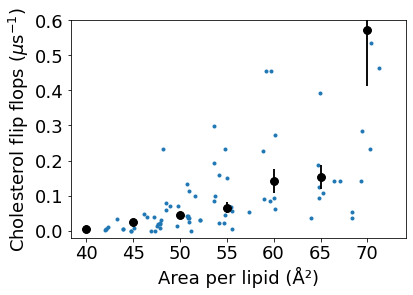

In [244]:
tmp = {}
for i in flipflops_dict:
    if 'CHOL' in flipflops_dict[i]:
        tmp[i] = flipflops_dict[i]
    
plotCorrelation('APL','CHOL',tmp)
result = plotXaveragedData('APL','CHOL',tmp,5,0)

plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Area per lipid (Å²)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('Cholesterol flip flops ($\mu \mathrm{s}^{-1}$)', fontsize = 18)
#plt.xlim([40,66])
#plt.ylim([-0.5,20])
plt.ylim([-0.02,0.6])
plt.savefig('../figures/CHOLflipflopVSapl.pdf',bbox_inches='tight')
plt.show()

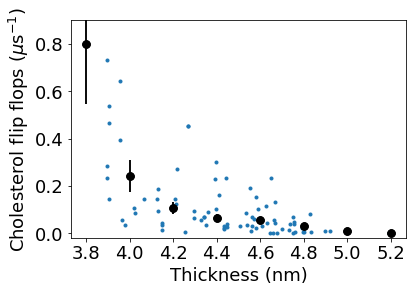

In [245]:
plotCorrelation('thickness','CHOL',tmp)
result = plotXaveragedData('thickness','CHOL',tmp,0.2,0)

plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Thickness (nm)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('Cholesterol flip flops ($\mu \mathrm{s}^{-1}$)', fontsize = 18)
#plt.xlim([40,66])
#plt.ylim([-0.5,20])
plt.ylim([-0.02,0.9])
plt.savefig('../figures/CHOLflipflopVSthickness.pdf',bbox_inches='tight')
plt.show()


#itemp = []
#logP = []
#logPerror = []
#for i in range(len(result[0])):
#    itemp.append(1000*1/result[0][i])
#    logP.append(np.log(result[1][i]))
#    logPerror.append(result[2][i] / result[1][i])
#    #plt.plot(1/results[0][i],np.log(results[1][i]),".")

#plt.errorbar(result[0],logP, yerr=logPerror, marker = ".", linestyle='', markersize =15, color = 'black')
#fitResult = scipy.stats.linregress(itemp, logP)
#print(fitResult)
##slope, intercept, rvalue, pvalue, stderr, intercept_stderr = fitResult
##print(fitResult.intercept_stderr)
#for i in fitResult:
#    print(i)
##print(fitResult[4])
#x = np.linspace(2.6,3.7,20)
#plt.plot(x, fitResult[0]*x + fitResult[1], color = 'black', lw = 3)
#plt.plot(x, (fitResult[0]-fitResult[4])*x + fitResult[1]+fitResult.intercept_stderr, color = 'black', lw = 1)
#plt.plot(x, (fitResult[0]+fitResult[4])*x + fitResult[1]-fitResult.intercept_stderr, color = 'black', lw = 1)
#plt.xlabel('1000*1/T', fontsize = 18)
#plt.xticks(fontsize = 18)
#plt.yticks(fontsize = 18)
#plt.ylabel('ln(P)', fontsize = 18)
##plt.savefig('../figures/TEMPERATUREvsPERMEATIONafit.pdf')
#plt.show()


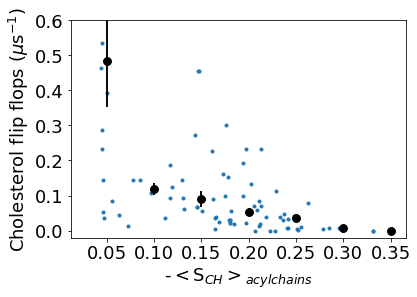

In [246]:
plotCorrelation('avgOP','CHOL',tmp)
result = plotXaveragedData('avgOP','CHOL',tmp,0.05,0)

plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('-$<$S$_{CH}>_{acyl chains}$', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('Cholesterol flip flops ($\mu \mathrm{s}^{-1}$)', fontsize = 18)
#plt.xlim([40,66])
#plt.ylim([-0.5,20])
plt.ylim([-0.02,0.6])
plt.savefig('../figures/CHOLflipflopVSorder.pdf',bbox_inches='tight')
plt.show()

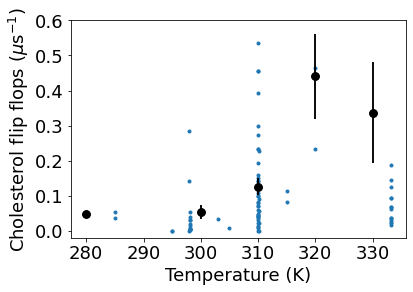

In [242]:
plotCorrelation('TEMPERATURE','CHOL',tmp)
result = plotXaveragedData('TEMPERATURE','CHOL',tmp,10,0)

plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='', markersize =15, color = 'black')
plt.xlabel('Temperature (K)', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('Cholesterol flip flops ($\mu \mathrm{s}^{-1}$)', fontsize = 18)
#plt.xlim([40,66])
#plt.ylim([-0.5,20])
plt.ylim([-0.02,0.6])
#plt.savefig('../figures/APLvsPERMEATION.pdf')
plt.show()

In [84]:
n_systems = len(systems)
#print(len(systems))
n_flipflops_sytems = np.zeros((n_systems,7), dtype=np.float64)
j = 0
flipflops_dict = {}
for i, system in enumerate(systems):
    if 'WARNINGS' in system and 'ORIENTATION' in system['WARNINGS'] and system['WARNINGS']['ORIENTATION'] == 'x-normal':
        continue
    if system['SOFTWARE'] == 'openMM':
        continue
        
    path = system['path']
    n_flipflops_sytems[i][2] = system['TEMPERATURE']
    time = system['TRJLENGTH']/1000000
    #n_flipflops_sytems[i][3] = time#*1000000/system['TRAJECTORY_SIZE']
    #print(n_flipflops_sytems[i][3])
    n_flipflops_sytems[i][4] = CalcAreaPerMolecule(system)
    
    try:
        n_flipflops_sytems[i][5] = GetThickness(system)
    except:
        n_flipflops_sytems[i][5] = 0
    try:
        n_flipflops_sytems[i][6] = averageOrderParameters(system)
    except:
        n_flipflops_sytems[i][6] = 0
    
    flipflops, names, list_names = getFlipflop(path)
    
    #print(list_names, path)
    
    if names != []:
        #print(list_names, path)
        mask = list(np.not_equal(flipflops[:,-1],0))
        names_masked = list(compress(names, mask))
        list_names = list(set(names_masked))
        if len(list_names) == 1:
            count = sum(system['COMPOSITION'][list_names[0]]['COUNT'])
            n_flipflops_sytems[i][0] = np.count_nonzero(flipflops[:,-1] == 1)/time/count
            n_flipflops_sytems[i][1] = np.count_nonzero(flipflops[:,-1] == 0)/time/count
            n_flipflops_sytems[i][3] = np.sort(flipflops[:,1])[0]


            if list_names[0] in flipflops_dict:
                flipflops_dict[list_names[0]] = np.append(flipflops_dict[list_names[0]], n_flipflops_sytems[i])

            else:
                flipflops_dict[list_names[0]] = np.array(n_flipflops_sytems[i])
        elif len(list_names) == 0:
            count = 1
        else:
            print('more then 1 lipid flipfloped... tba')
        j +=1
for name in flipflops_dict.keys():
    flipflops_dict[name] = np.reshape(flipflops_dict[name],(-1,7))
    #print(flipflops_dict[name])
    
#print(flipflops_dict)
    
#print(n_flipflops_sytems[:,3])
print(j)
#print(n_flipflops_sytems)



no file
no file
130


[]

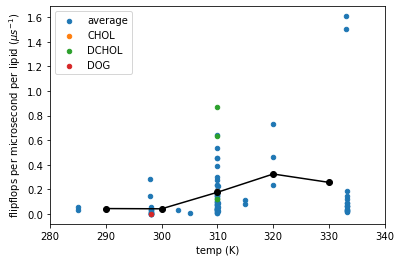

In [85]:
mask = np.not_equal(n_flipflops_sytems[:,0],0)
flipflips_masked = n_flipflops_sytems[mask]

avg_flipflops, bined_T, foo = stats.binned_statistic(
                             flipflips_masked[:,2], 
                             flipflips_masked[:,0], 
                             statistic='mean', 
                             bins=6, 
                             range=(275, 335))
avg_flipflops = np.nan_to_num(avg_flipflops)
mask = np.not_equal(avg_flipflops, 0)

avg_flipflops = avg_flipflops[mask] 
bined_T = bined_T[:-1][mask] + 5

names = list(flipflops_dict.keys())
names.sort()
for name in names:
    plt.scatter(flipflops_dict[name][:,2], flipflops_dict[name][:,0], s = 20)
plt.scatter(bined_T, avg_flipflops, c = 'k')
plt.plot(bined_T, avg_flipflops, c = 'k')
plt.legend(['average','CHOL','DCHOL','DOG'])
plt.xlim(280, 340)
plt.xlabel('temp (K)')
plt.ylabel('flipflops per microsecond per lipid ($\mu$$s^{-1}$)')
plt.plot()

 
-5.327 x + 15.13


[]

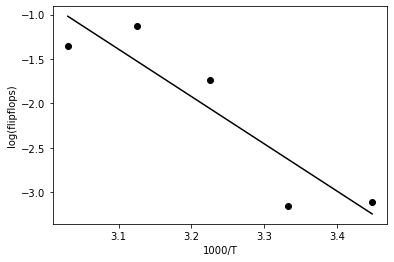

In [9]:
inv_T = 1000/bined_T
fliplops_loged = np.log(avg_flipflops)

polynome = np.polyfit(inv_T, fliplops_loged, 1)
p = np.poly1d(polynome)
print(p)

plt.scatter(inv_T, fliplops_loged, c = 'k')
plt.plot(inv_T, p(inv_T), c = 'k')
#plt.ylim(-1, 50)
plt.xlabel('1000/T')
plt.ylabel('log(flipflops)')
plt.plot()

['CHOL', 'DCHOL', 'DOG', 'POPC']


[]

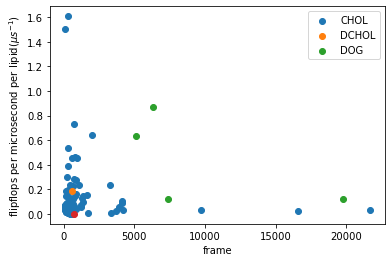

In [10]:
mask = np.not_equal(n_flipflops_sytems[:,0],0)
flipflops_masked = n_flipflops_sytems[mask]


#plt.scatter(flipflops_masked[:,3], flipflops_masked[:,0])
names = list(flipflops_dict.keys())
names.sort()
print(names)
for name in names:
    plt.scatter(flipflops_dict[name][:,3], flipflops_dict[name][:,0])
plt.legend(['CHOL','DCHOL','DOG'])
#plt.xlim(-1, 50)
plt.xlabel('frame')
plt.ylabel('flipflops per microsecond per lipid($\mu$$s^{-1}$)')
plt.plot()



(0.5509454923998125, 0.00012893554134368518)


[]

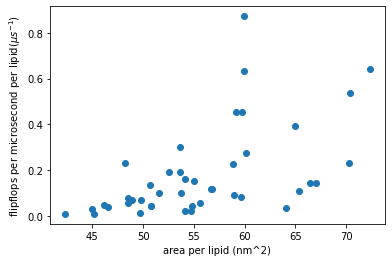

In [11]:
mask = np.not_equal(n_flipflops_sytems[:,0],0)
flipflips_masked = n_flipflops_sytems[mask]



#checking system with temp ~310K
mask = np.greater(flipflips_masked[:,2],308)
flipflips_masked = flipflips_masked[mask]
mask = np.less(flipflips_masked[:,2],312)
flipflips_masked = flipflips_masked[mask]

print(stats.pearsonr(flipflips_masked[:,4], flipflips_masked[:,0]))

plt.scatter(flipflips_masked[:,4], flipflips_masked[:,0])
#plt.ylim(-1, 50)
plt.xlabel('area per lipid (nm^2)')
plt.ylabel('flipflops per microsecond per lipid($\mu$$s^{-1}$)')
plt.plot()

(-0.38285904983182234, 0.011278018078506076)


[]

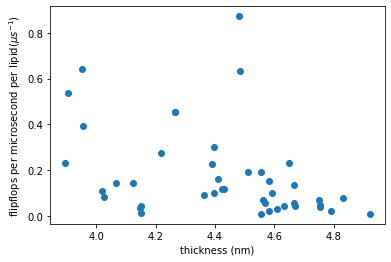

In [12]:
mask = np.not_equal(n_flipflops_sytems[:,0],0)
flipflips_masked = n_flipflops_sytems[mask]

#checking system with temp ~310K
mask = np.greater(flipflips_masked[:,2],308)
flipflips_masked = flipflips_masked[mask]
mask = np.less(flipflips_masked[:,2],312)
flipflips_masked = flipflips_masked[mask]

print(stats.pearsonr(flipflips_masked[:,5], flipflips_masked[:,0]))

plt.scatter(flipflips_masked[:,5], flipflips_masked[:,0])
#plt.ylim(-1, 50)
plt.xlabel('thickness (nm)')
plt.ylabel('flipflops per microsecond per lipid($\mu$$s^{-1}$)')
plt.plot()

(0.21461740258030998, 0.05137037607549313)


[]

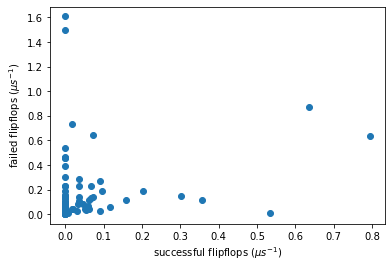

In [13]:
mask = np.not_equal(n_flipflops_sytems[:,0],0)
flipflips_masked = n_flipflops_sytems[mask]

print(stats.pearsonr(flipflips_masked[:,1], flipflips_masked[:,0]))

plt.scatter(flipflips_masked[:,1], flipflips_masked[:,0])
#lt.xlim(0, 1.7)
plt.xlabel('successful flipflops ($\mu$$s^{-1}$)')
plt.ylabel('failed flipflops ($\mu$$s^{-1}$)')
plt.plot()

(-0.5544566635380086, 0.00011434072295098495)


[]

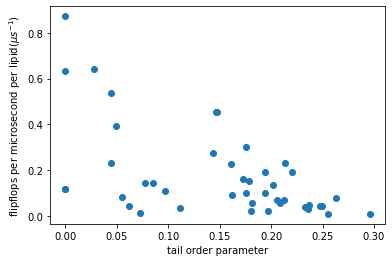

In [14]:
mask = np.not_equal(n_flipflops_sytems[:,0],0)
flipflips_masked = n_flipflops_sytems[mask]

#checking system with temp ~310K

mask = np.greater(flipflips_masked[:,2],308)
flipflips_masked = flipflips_masked[mask]
mask = np.less(flipflips_masked[:,2],312)
flipflips_masked = flipflips_masked[mask]

print(stats.pearsonr(flipflips_masked[:,6], flipflips_masked[:,0]))

plt.scatter(flipflips_masked[:,6], flipflips_masked[:,0])
#plt.ylim(-1, 50)
plt.xlabel('tail order parameter')
plt.ylabel('flipflops per microsecond per lipid($\mu$$s^{-1}$)')
plt.plot()

In [34]:
for system in systems:
    path = system['path']
    #print(path)
    temperature = system['TEMPERATURE']
    if temperature > 330:
        
        flipflops, names, list_names = getFlipflop(path)
        #time = system['TRJLENGTH']/1000000
        #count = sum(system['COMPOSITION'][list_names[0]]['COUNT'])
        #np.count_nonzero(flipflops[:,-1] == 1)/time/count
        
        
        
        if len(flipflops) > 0:
            #print(np.count_nonzero(flipflops[:,-1] == 1))
            #print(system)
        #print(list_names)
            #if 'POPC' in list_names:
            print(flipflops, names, list_names)
            print(path)

            

[[ 80 744 749   1   1]] ['CHOL'] ['CHOL']
../Data/Flipflops/ca9/5ea/ca95eaec9e05d0b4ef1d99e1c4577f0e4cec455c/3abfac8381036ab1ab6d06199cf5cc480c1963b0/
[[ 69 670 673   1   1]] ['CHOL'] ['CHOL']
../Data/Flipflops/dec/cb5/deccb577ca8ad6e421736887bee86a9205242916/40169c0c0397357618cdad94ea374018fe4bc318/
[[1049  374  381    1    1]
 [1067  788  793    1    1]
 [1073  301  304    1    1]
 [1127  165  169    1    1]
 [1129  880  887   -1    1]
 [1162  547  552   -1    1]
 [1169  246  251    1    1]
 [1222  664  672    1    1]
 [1232  563  570    1    1]
 [1233  759  763   -1    1]
 [1254  847  851    1    1]
 [1257  117  121    1    1]
 [1270  551  555   -1    1]
 [1281  586  591    1    1]
 [1285  323  327   -1    1]
 [1286  301  304   -1    1]
 [1297  608  613   -1    1]
 [1304  264  267    1    1]
 [1304  421  425   -1    1]
 [1316  442  448   -1    1]
 [1333  534  555    1    1]
 [1338  671  674   -1    1]
 [1358  334  337    1    1]
 [1382  322  324    1    1]
 [1397  822  829   -1    1

In [35]:
n_flipflops_sytems

array([[0.00000000e+00, 0.00000000e+00, 3.03000000e+02, ...,
        5.48160002e+01, 4.53331986e+00, 2.23307893e-01],
       [9.08909127e-02, 0.00000000e+00, 3.10150000e+02, ...,
        5.89123097e+01, 4.36200128e+00, 1.62091906e-01],
       [0.00000000e+00, 0.00000000e+00, 3.10000000e+02, ...,
        6.49671402e+01, 4.12439278e+00, 1.28372804e-01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 3.10150000e+02, ...,
        5.81211126e+01, 4.73922574e+00, 1.78436266e-01],
       [0.00000000e+00, 0.00000000e+00, 2.98000000e+02, ...,
        6.19764423e+01, 4.36055420e+00, 1.58670782e-01],
       [0.00000000e+00, 0.00000000e+00, 3.20000000e+02, ...,
        6.49860033e+01, 4.25687750e+00, 1.40405030e-01]])

In [42]:
for i in flipflops_dict['CHOL']:
    print(i[0],i[2])
    

0.0908909127265456 310.15
0.08331666999933347 315.0
0.3928178610710358 310.0
0.01921155767309614 298.15
0.029844777313194078 310.0
0.022726136420451702 310.15
0.14284285857128573 310.0
0.046509302441854646 310.0
0.2321312505803281 310.0
0.45431829539775564 310.0
0.29985007496251875 310.0
0.004459825888397317 298.15
0.031218781218781223 298.15
0.05681108043312768 310.15
0.10713214392846429 310.0
0.003902347652347653 298.15
0.058110479643898975 310.0
0.15996800639872025 310.0
0.07953750079537501 310.0
0.04463839330352679 310.0
0.06243756243756245 333.15
0.46423929035667866 320.0
0.1248751248751249 333.15
0.03571071464282143 285.0
0.11362500113625001 315.0
0.06724045185583648 333.15
0.2324419185755959 310.0
0.14284285857128573 310.0
0.009998000399920015 310.0
0.1922115865144351 310.0
0.037462537462537464 333.15
1.4998500149985001 333.0
0.01783930355358927 333.15
0.09995002498750624 310.0
0.006243756243756245 298.15
0.06999650017499125 310.0
0.08332500083325001 310.0
0.45431829539775564 31

In [43]:
tst = []
tst[0] =1

IndexError: list assignment index out of range